In [1]:
# run_basset
import anndata
import h5py
import scipy
import os
import math
import pickle
import glob
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
from sklearn import metrics
from scbasset.utils import *


### read the model

In [2]:
ad = anndata.read_h5ad('../../data/downloads/buen_ad.h5ad')
model = make_model(32, ad.shape[0], show_summary=False)
model.load_weights('../../data/downloads/buen_model.h5')

2022-03-23 21:38:24.569534: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-03-23 21:38:24.569598: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gpu-2-snapshot): /proc/driver/nvidia/version does not exist
2022-03-23 21:38:24.570258: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### test data

In [3]:
seqs_dna, seqs_coords = make_bed_seqs('../../data/lcr.bed', 
                                      fasta_file='/home/yuanh/genomes/hg19/hg19.fa', 
                                      seq_len=1344)
seq_ref_1hot = dna_1hot(seqs_dna[0])

### run ism

In [4]:
m = ism(seq_ref_1hot, model)
np.save('ism.npy', m)

2022-03-23 21:38:28.511425: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


### visualization

In [10]:
import logomaker

def plot_logo(m, ymin, ymax, ax, title):
    nn_logo = logomaker.Logo(m, ax=ax, baseline_width=0)
    # style using Logo methods
    nn_logo.style_spines(visible=False)
    nn_logo.style_spines(spines=['left'], visible=True, bounds=[ymin, ymax])
    ax.set_ylabel('    saliency', labelpad=-1)
    ax.set_title(title)
    ax.set_ylim(ymin, ymax)
    return(f)

In [8]:
ct = ad.obs['label'].cat.categories
a = np.load('ism.npy')
seq_ref_1hot = dna_1hot(seqs_dna[0])

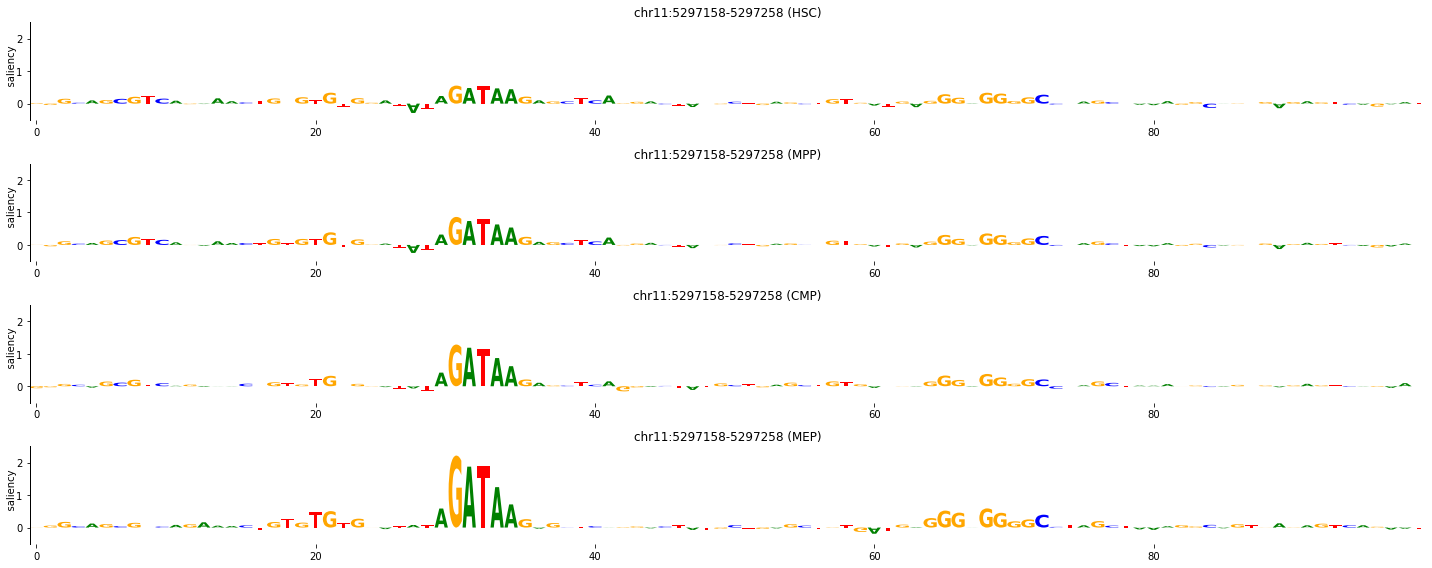

In [11]:
f, axs = plt.subplots(nrows=4, figsize=(20, 8))
cts = ['HSC','MPP','CMP','MEP']
for i in range(4):
    # aggregate cells
    cells = np.where((ad.obs['label']==cts[i]))[0]
    agg_profile = a[cells,:,:].mean(axis=0)
    # normalize
    profile_norm = agg_profile - np.repeat(agg_profile.mean(axis=1)[:,np.newaxis], 4, axis=1)
    # plot
    toplot = pd.DataFrame(seq_ref_1hot * profile_norm, columns = ['A', 'C', 'G', 'T'])
    toplot = toplot.iloc[720:820,:]
    toplot.index = np.arange(toplot.shape[0])
    plot_logo(toplot, -0.5, 2.5, axs[i], '%s:%d-%d (%s)'%(seqs_coords[0][0],seqs_coords[0][1]+720, seqs_coords[0][1]+820, cts[i]))

f.tight_layout()
#f.savefig('mep_lineage.pdf')

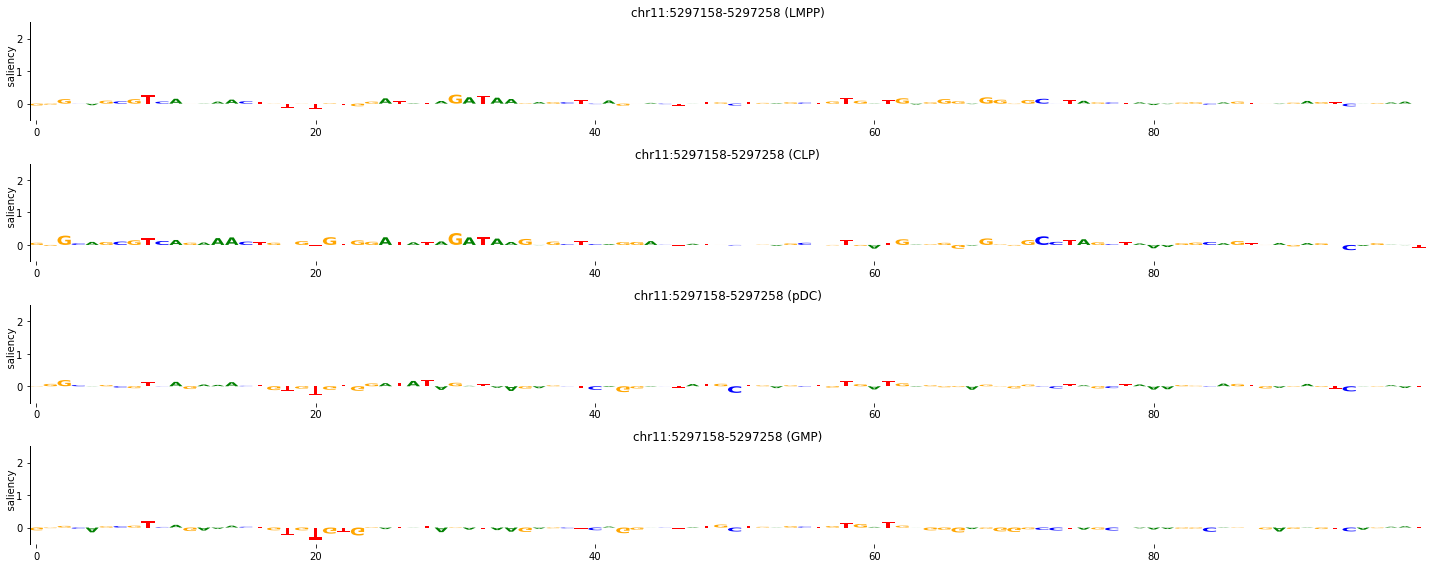

In [12]:
f, axs = plt.subplots(nrows=4, figsize=(20, 8))
cts = ['LMPP','CLP','pDC','GMP']
for i in range(4):
    # aggregate cells
    cells = np.where((ad.obs['label']==cts[i]))[0]
    agg_profile = a[cells,:,:].mean(axis=0)
    # normalize
    profile_norm = agg_profile - np.repeat(agg_profile.mean(axis=1)[:,np.newaxis], 4, axis=1)
    # plot
    toplot = pd.DataFrame(seq_ref_1hot * profile_norm, columns = ['A', 'C', 'G', 'T'])
    toplot = toplot.iloc[720:820,:]
    toplot.index = np.arange(toplot.shape[0])
    plot_logo(toplot, -0.5, 2.5, axs[i], '%s:%d-%d (%s)'%(seqs_coords[0][0],seqs_coords[0][1]+720, seqs_coords[0][1]+820, cts[i]))
f.tight_layout()
#f.savefig('other_lineages.pdf')